In [2]:
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

import warnings
import numpy as np
import pandas as pd

In [3]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

# Data Check

In [4]:
wti = pd.read_csv('Database/oils/WTI.csv', index_col=0)
bno = pd.read_csv('Database/oils/BNO.csv', index_col=0)

In [5]:
wti['Adj Close']

Date
2017-12-01    3.465902
2017-12-04    3.346730
2017-12-05    3.396385
2017-12-06    3.028940
2017-12-07    3.058733
                ...   
2024-03-11    2.579681
2024-03-12    2.490040
2024-03-13    2.539840
2024-03-14    2.500000
2024-03-15    2.590000
Name: Adj Close, Length: 1581, dtype: float64

In [6]:
bno['Adj Close']

Date
2017-12-01    17.180000
2017-12-04    16.830000
2017-12-05    16.969999
2017-12-06    16.510000
2017-12-07    16.730000
                ...    
2024-03-11    29.969999
2024-03-12    29.870001
2024-03-13    30.580000
2024-03-14    31.000000
2024-03-15    31.030001
Name: Adj Close, Length: 1581, dtype: float64

# General preprocessing

In [7]:
wti['return'] = wti['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
bno['return'] = bno['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))

In [8]:
wti_vol = wti['return'].rolling(window=5).std()
bno_vol = bno['return'].rolling(window=5).std()

In [9]:
wti_vol = wti_vol.iloc[20:]
bno_vol = bno_vol.iloc[20:]

In [10]:
# test_wti = wti_vol.iloc[-52:]
# test_bno = bno_vol.iloc[-52:]

In [11]:
# train_wti = wti_vol.iloc[:-52]
# train_bno = bno_vol.iloc[:-52]

,Date,Prediction,Ground Truth
0,2024-03-11,0.038244,0.036363
1,2024-03-12,0.044184,0.035569
2,2024-03-13,0.045737,0.020369
3,2024-03-14,0.045436,0.020834
4,2024-03-15,0.044574,0.028046


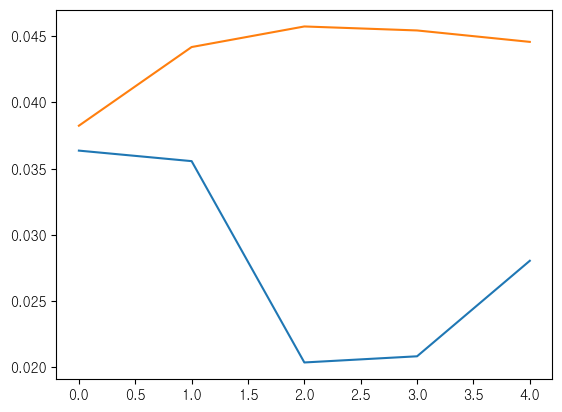

In [19]:
pred=pd.read_csv('Files/bi_LSTM_wti.csv')

pred

import matplotlib.pyplot as plt

plt.plot(pred['Ground Truth'])
plt.plot(pred['Prediction'])

In [72]:
wti_vol

Date
2018-01-02                                              0.05546
2018-01-03                                             0.062227
2018-01-04                                             0.060366
2018-01-05                                             0.056537
2018-01-08                                             0.050013
                                    ...                        
2024-03-12                                             0.035569
2024-03-13                                             0.020369
2024-03-14                                             0.020834
2024-03-15                                             0.028046
emb           [[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], ...
Name: return, Length: 1562, dtype: object

# Save Files

In [80]:
wti_vol.to_csv('Database/oil_std/wti_vol.csv')
bno_vol.to_csv('Database/oil_std/bno_vol.csv')